# Exploratory Data Analysis: The Active Orbital Population

**Dataset:** Cleaned UCS Satellite Database  
**Objective:** Characterize the operational environment of Low Earth Orbit (LEO) by analyzing ownership, mass distribution, and launch trends.

### **The Analytical Strategy**
Before modeling the total debris environment, we must understand the baseline of active assets. This analysis focuses on:
1.  **Mass Profiling:** Visualizing the weight distribution of the active fleet to identify "High-Value" targets.
2.  **Stakeholder Analysis:** Mapping the shift from Government/Military dominance to Commercial proliferation.
3.  **Temporal Dynamics:** Modeling the transition from linear historical growth to the exponential "New Space" acceleration.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, brentq

In [2]:
ucs_cleaned = pd.read_csv('../../data/clean/ucs_cleaned.csv', parse_dates=['launch_date'])

sns.set_theme(style="whitegrid")

### **Analysis: Active Payload Mass Distribution**
**The Problem:** Kinetic risk is a function of both velocity and mass. Characterizing the "typical" mass of an active satellite allows us to differentiate between the impact of a standard commercial payload and massive operational outliers.

**The Solution:** Utilize a histogram with a Kernel Density Estimate (KDE) to identify the primary "weight classes" of the current operational fleet. This establishes the baseline for the "Tier 1" mass proxies used in the global clutter model.

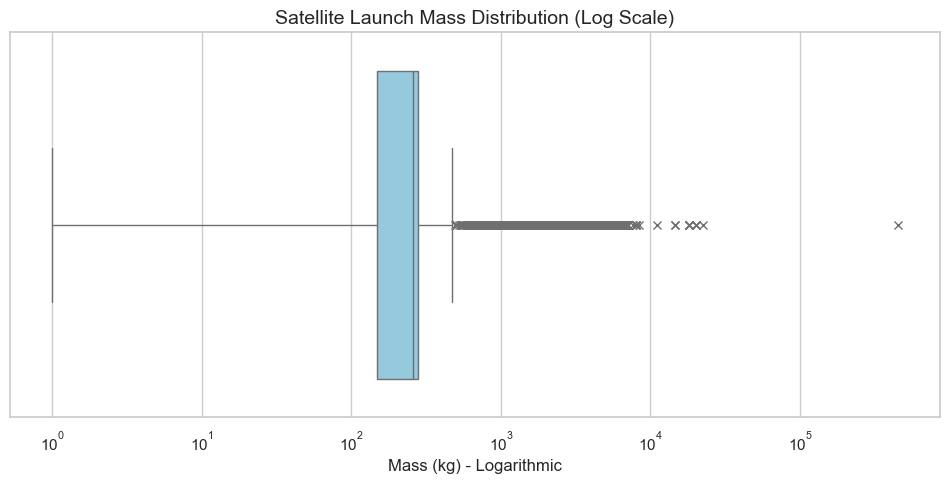

In [3]:
plt.figure(figsize=(12, 5))
sns.boxplot(x=ucs_cleaned['launch_mass_kg'], color='skyblue', 
            flierprops={"marker": "x", "markerfacecolor": "red"})

plt.xscale('log')

plt.title('Satellite Launch Mass Distribution (Log Scale)', fontsize=14)
plt.xlabel('Mass (kg) - Logarithmic', fontsize=12)
plt.show()

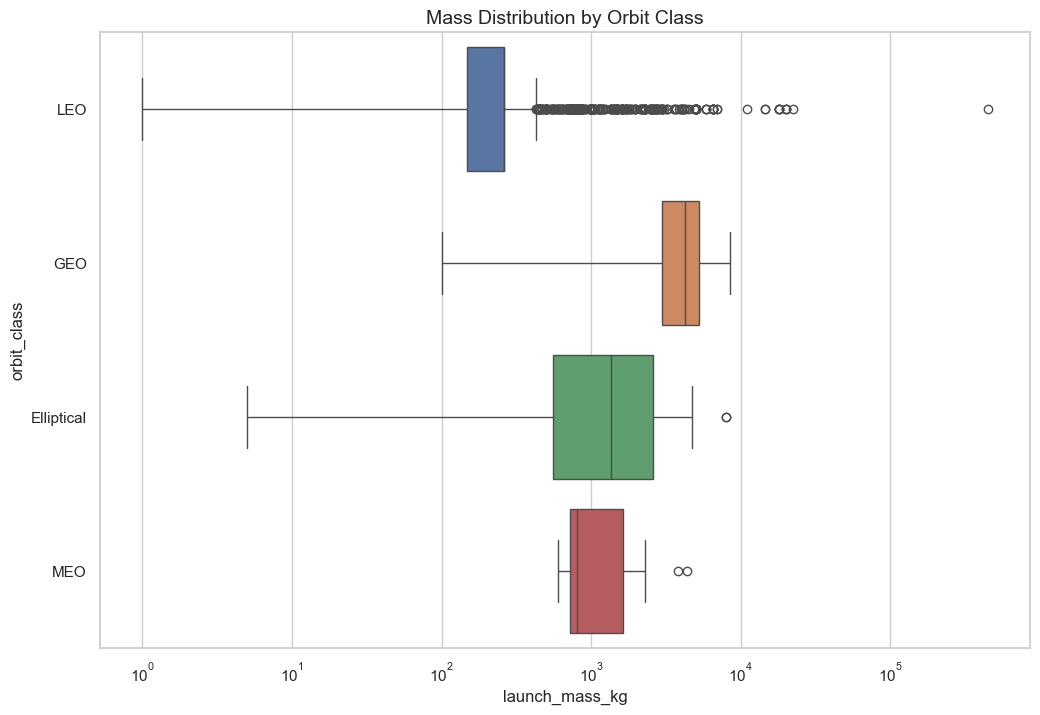

In [4]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=ucs_cleaned, 
            x='launch_mass_kg', 
            y='orbit_class', 
            hue='orbit_class', 
            legend=False)

plt.xscale('log')

plt.title('Mass Distribution by Orbit Class', fontsize=14)
plt.show()

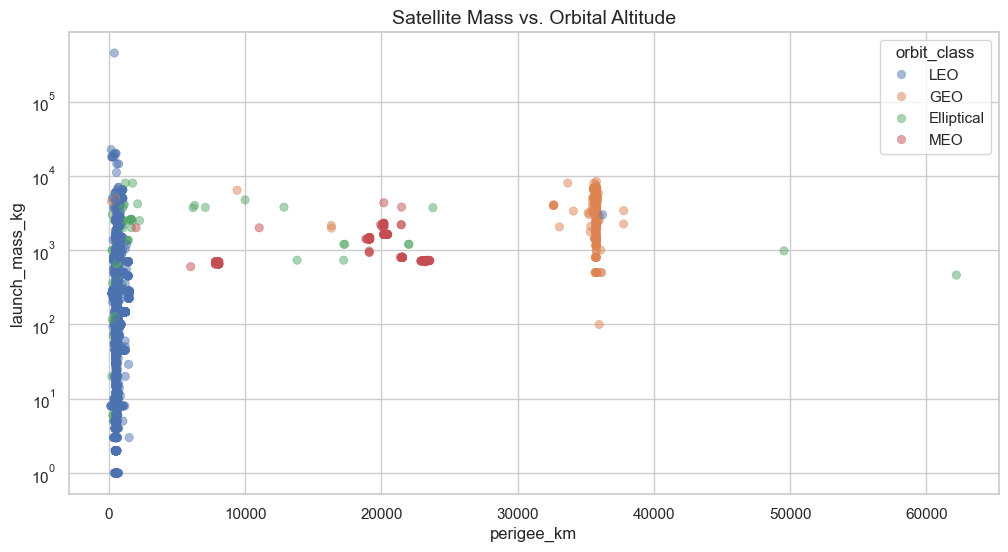

In [5]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
                data = ucs_cleaned,
                x = 'perigee_km',
                y = 'launch_mass_kg', 
                hue = 'orbit_class',
                alpha = 0.5,
                edgecolor = None)

plt.yscale('log')
plt.title('Satellite Mass vs. Orbital Altitude', fontsize=14)
plt.show()

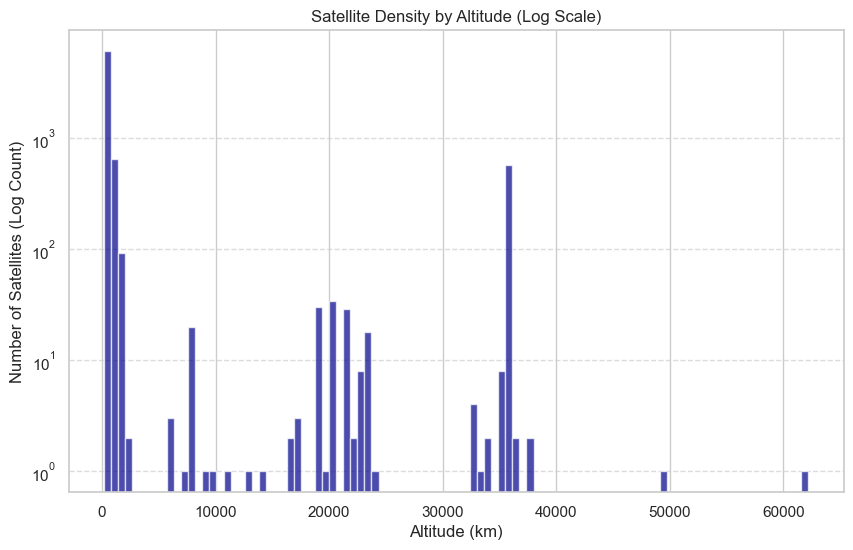

In [6]:
plt.figure(figsize=(10,6))
plt.hist(ucs_cleaned['perigee_km'], bins=100, color='darkblue', alpha=0.7)
plt.yscale('log') 
plt.title('Satellite Density by Altitude (Log Scale)')
plt.xlabel('Altitude (km)')
plt.ylabel('Number of Satellites (Log Count)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<Axes: xlabel='launch_date'>

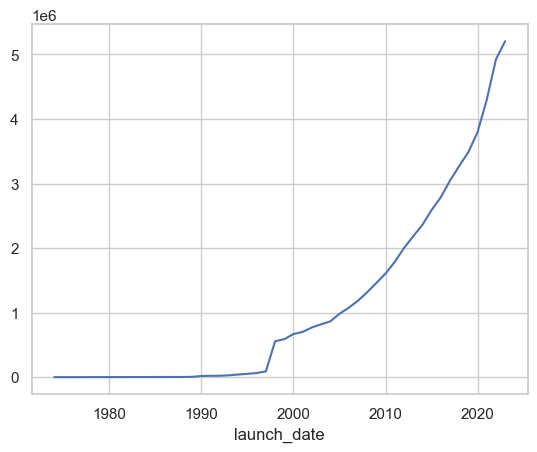

In [7]:
mass_trend = ucs_cleaned.groupby(ucs_cleaned['launch_date'].dt.year)['launch_mass_kg'].sum().cumsum()
mass_trend.plot()

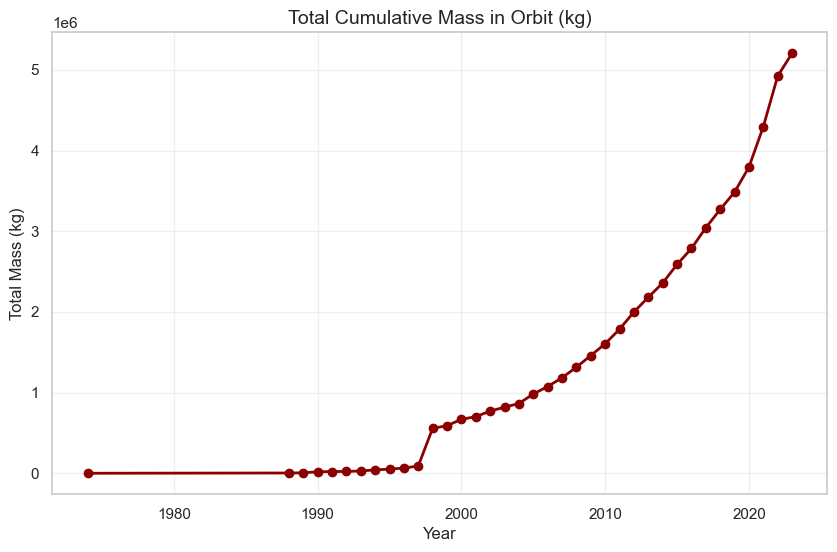

In [8]:
mass_by_year = ucs_cleaned.groupby(ucs_cleaned['launch_date'].dt.year)['launch_mass_kg'].sum().cumsum()

plt.figure(figsize=(10, 6))

mass_by_year.plot(kind='line', marker='o', color='darkred', linewidth=2)

plt.title('Total Cumulative Mass in Orbit (kg)', fontsize=14)
plt.ylabel('Total Mass (kg)')
plt.xlabel('Year')
plt.grid(True, alpha=0.3)
plt.show()

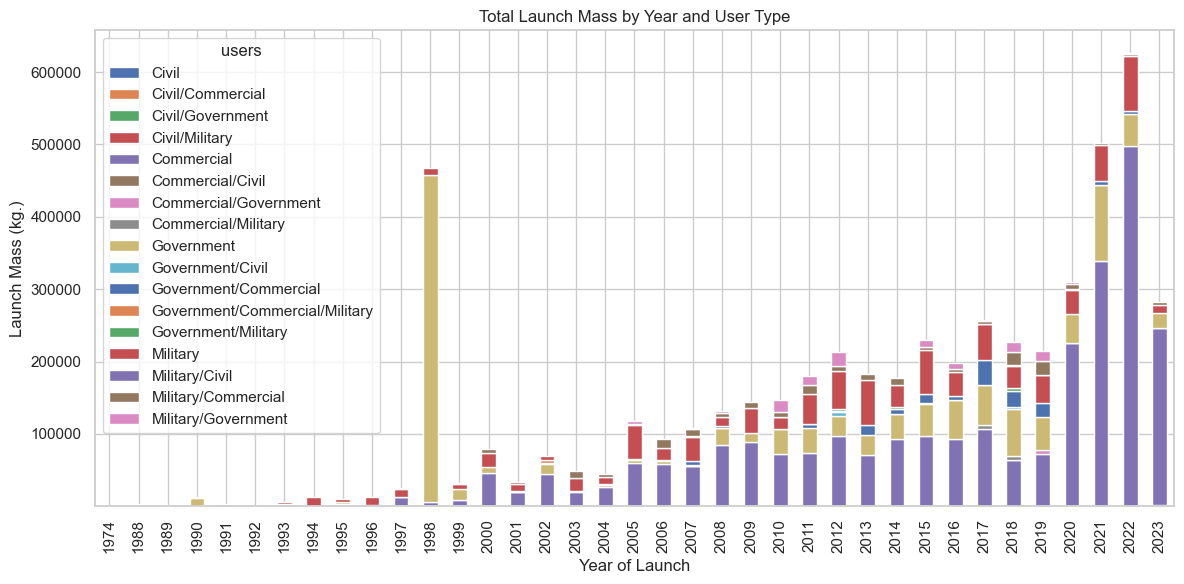

In [9]:
ucs_cleaned['launch_date'] = pd.to_datetime(ucs_cleaned['launch_date'])

ucs_cleaned['Year'] = ucs_cleaned['launch_date'].dt.year

summary = ucs_cleaned.pivot_table(
    index='Year',
    columns='users',
    values='launch_mass_kg',
    aggfunc='sum',
    observed=False
)

summary.plot(kind='bar', figsize=(12, 6), rot=90, stacked=True)

plt.title("Total Launch Mass by Year and User Type")
plt.ylabel("Launch Mass (kg.)")
plt.xlabel("Year of Launch")
plt.tight_layout()
plt.show()

This is where I will start to organize my thoughts properly, start asking questions, and begin telling this datasets stories. I am leaving everything I have already added, for reference, until I reorganize everything as I want it.

# Democratization of Space

Democratization of space is the story of how space travel shifted from being exclusively superpowers (USA, Russia, China) to an open market of private companies, universities, and developing countries.

# Old Space

The following visualization shows that space was dominated by just a handful of superpowers pre-2012.

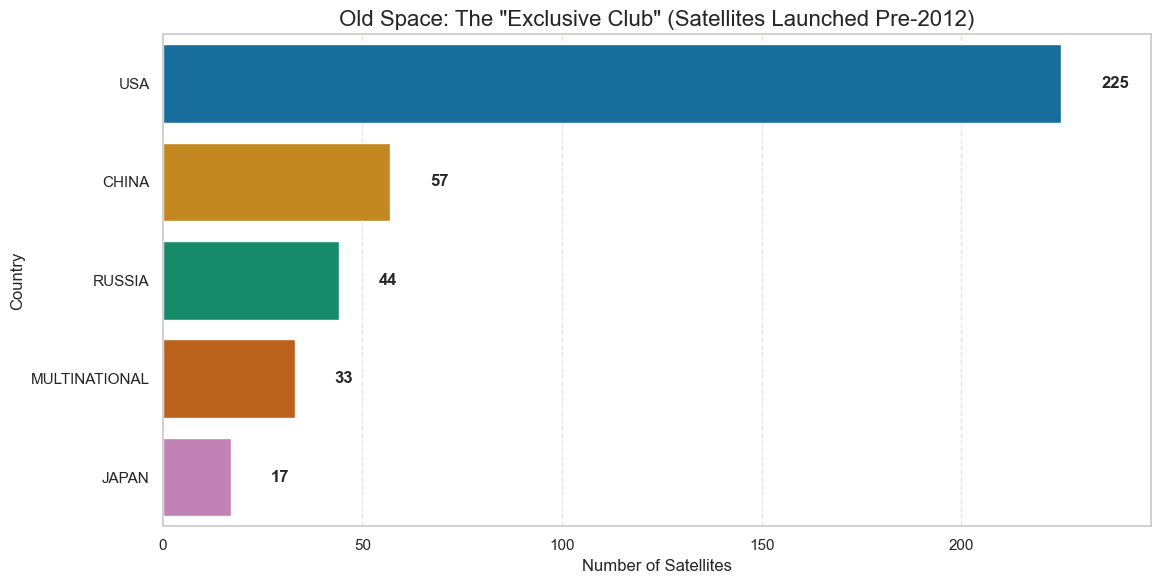

In [10]:
# Old Space
old_space = ucs_cleaned[ucs_cleaned['Year'] < 2012]

country_counts_old = old_space['country_operator'].value_counts().head(5)

plt.figure(figsize=(12, 6))
sns.barplot(x=country_counts_old.values, y=country_counts_old.index, hue=country_counts_old.index, palette='colorblind')

plt.title('Old Space: The "Exclusive Club" (Satellites Launched Pre-2012)', fontsize=16)

plt.xlabel('Number of Satellites')
plt.ylabel('Country')

plt.grid(axis='x', linestyle='--', alpha=0.5)

for i, v in enumerate(country_counts_old.values):
    plt.text(v + 10, i, str(v), va='center', fontweight='bold')

plt.tight_layout()

# Get the current maximum x-value and add 10% padding
plt.xlim(right=country_counts_old.max() * 1.1)

plt.show()

The following 2 visualtions show that space used to be reserved for big governments and military applications. It may appear that commercial has a larger slice, but 40% commercial is still less than 60% Military/Government/Civil. Mathmatically, non-commercial users still held the majority.

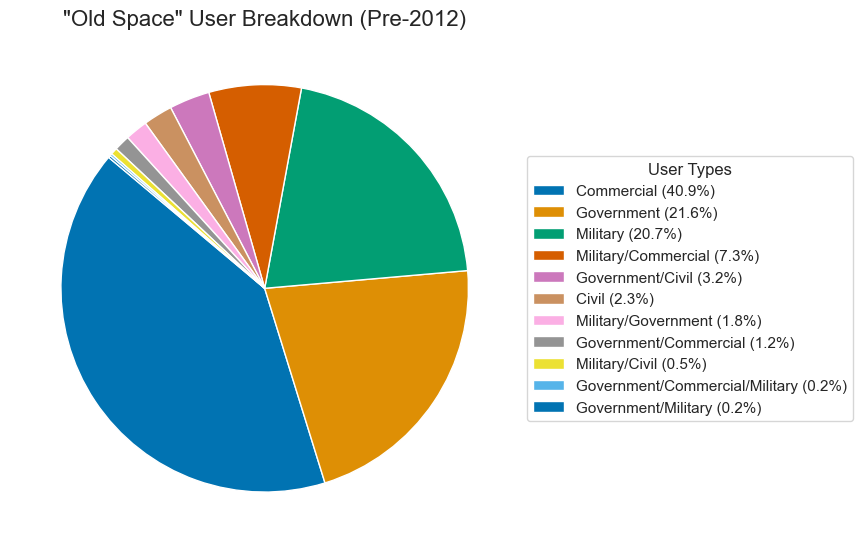

In [11]:
# get all users before 2012 and then count the number of times that user appears in the dataset before 2012
old_space = ucs_cleaned[ucs_cleaned['Year'] < 2012]
user_counts_old = old_space['users'].value_counts()

total = user_counts_old.sum()
percentages = [(x / total * 100) for x in user_counts_old]
legend_labels = [f'{l} ({s:1.1f}%)' for l, s in zip(user_counts_old.index, percentages)]

fig, ax = plt.subplots(figsize=(8, 6))

wedges, texts = ax.pie(
    user_counts_old,
    wedgeprops={'width': 1},
    startangle=140,
    colors=sns.color_palette('colorblind')
)

ax.legend(wedges, legend_labels,
          title="User Types",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1)) # anchor legend to the right of the box so it doesnt obstruct the pie view

plt.title('"Old Space" User Breakdown (Pre-2012)', fontsize=16)
plt.tight_layout()
plt.show()

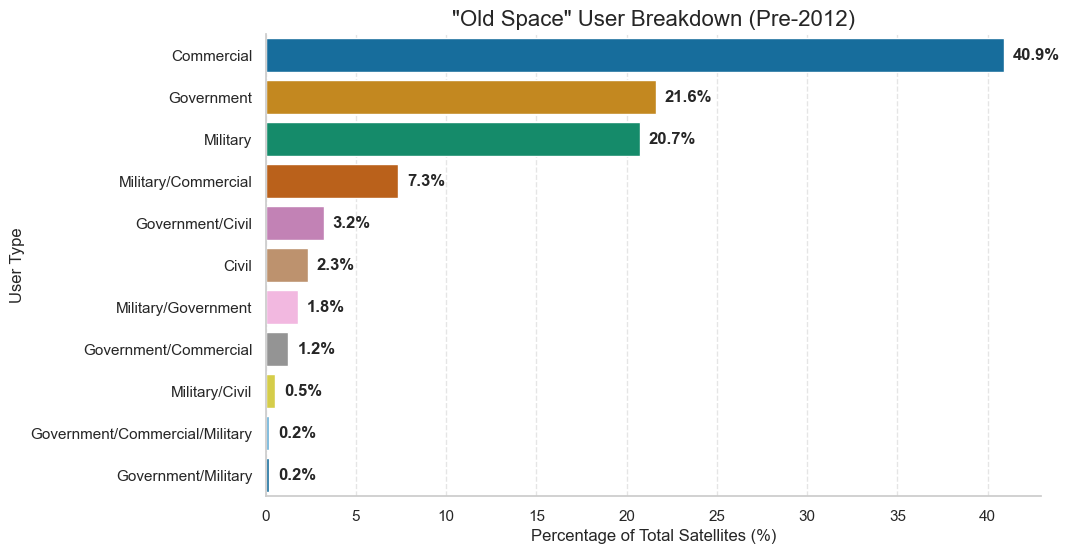

In [12]:
old_space = ucs_cleaned[ucs_cleaned['Year'] < 2012]
user_counts_old = old_space['users'].value_counts()

user_pcts_old = (user_counts_old / user_counts_old.sum()) * 100

plt.figure(figsize=(10, 6))

sns.barplot(x=user_pcts_old.values, y=user_pcts_old.index, hue=user_pcts_old.index, palette='colorblind')

plt.title('"Old Space" User Breakdown (Pre-2012)', fontsize=16)
plt.xlabel('Percentage of Total Satellites (%)')
plt.ylabel('User Type')
plt.grid(axis='x', linestyle='--', alpha=0.5)

for i, v in enumerate(user_pcts_old.values):
    plt.text(v + .5, i, f'{v:.1f}%', va='center', fontweight='bold')
sns.despine()
plt.show()

The next visualization shows the explosion of the commercial sector in space.

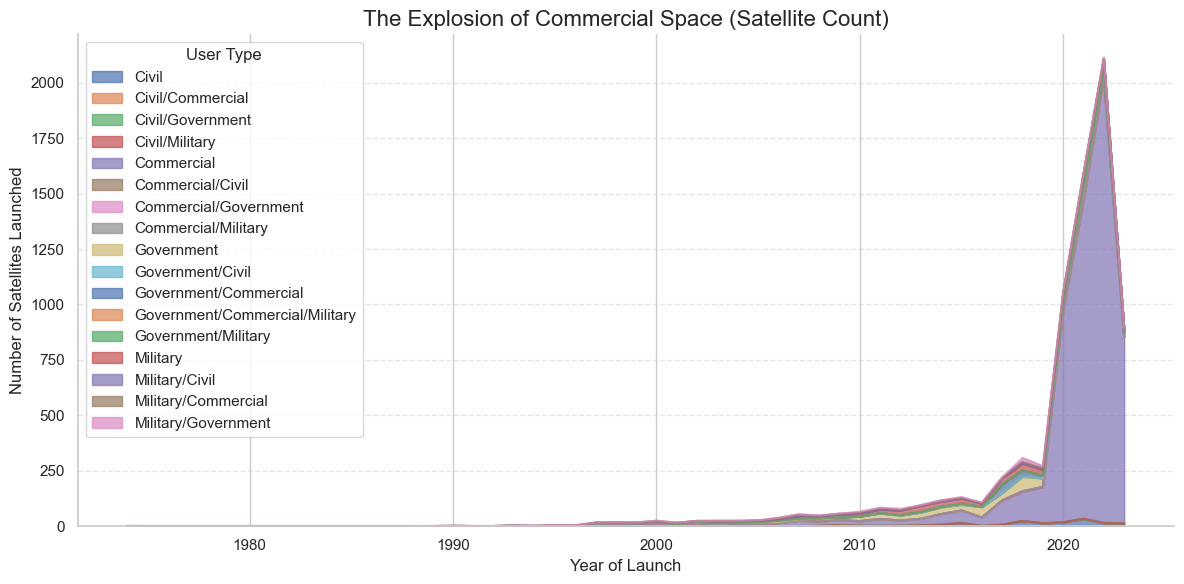

In [13]:
sat_counts = ucs_cleaned.pivot_table(
    index='Year', 
    columns='users', 
    values='satellite_name', 
    aggfunc='count'
).fillna(0)

ax = sat_counts.plot(kind='area', stacked=True, figsize=(12, 6), alpha=0.7)

plt.title('The Explosion of Commercial Space (Satellite Count)', fontsize=16)
plt.ylabel('Number of Satellites Launched')
plt.xlabel('Year of Launch')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='User Type')
sns.despine()
plt.tight_layout()
plt.show()

The next visualization shows where we are headed with this, the 'Crowded Skies' view so to speak.  This chart shows how orbital debris collection isnt happening evenly, its not spread out across all of earths orbits etc. This will show that while GEO orbit is stable, the increase in debris within LEO orbit is exponential so this is where the debris clutter risk is the highest. The following visualization is appropriate because it clearly shows the number of objects launched, for each year, within each orbit class.  This shows the debris distribution to be climbing exponentially within the LEO orbit class specficially. I ensured accurracy by comparing exponential growth vs linear growth. I will almost always try to use pallettes such as 'colorblind', where possible, for neutral accessability color options.  I also like to make visualizations a bit on the larger side to improve visibility.

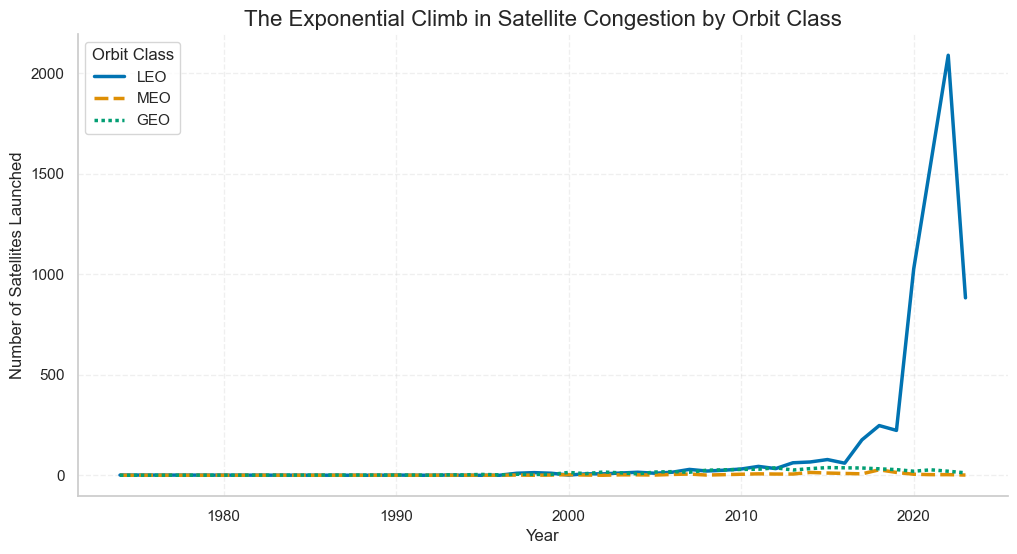

In [14]:
orbit_evolution = ucs_cleaned.pivot_table(
    index='Year', # rows
    columns='orbit_class', # columns 
    values='satellite_name', # data to count, almost anything could have done, but satellite_name works for counting unique objects
    aggfunc='count' # count the number of times a satellite name appears for this year and orbit class.
).fillna(0)

# Focus on the main 3 classes to avoid clutter, elliptical isnt really needed its just noise.
# Elliptical orbit sates are not really a risk, there are literally a couple dozen within the elliptical orbit.
# Leo orbit is where all the clutter is starting to pile up.  All of the commercial flights, launch debris, sate
# debris that is collecting and not deorbiting within the LEO orbit.
main_orbits = orbit_evolution[['LEO', 'MEO', 'GEO']]

plt.figure(figsize=(12, 6))
sns.lineplot(data=main_orbits, palette='colorblind', linewidth=2.5)

plt.title('The Exponential Climb in Satellite Congestion by Orbit Class', fontsize=16)
plt.ylabel('Number of Satellites Launched')
plt.xlabel('Year')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(title='Orbit Class')

sns.despine()

plt.show()

### **Stage 4.0: Aggregating Launch Trends**
**The Problem:** To model growth dynamics effectively, we require a time-series dataset that represents the total number of satellite deployments per year. The raw registry exists as individual object entries rather than an annual count.

**The Solution:**
* **Feature Extraction:** Derive the `launch_year` from the standardized `launch_date` datetime objects.
* **Relational Aggregation:** Group the registry by year and calculate the population size for each period.
* **Validation:** Generate a `yearly_counts` dataframe to serve as the input for subsequent curve-fitting and trend analysis.

In [15]:
# Extract the year from the launch_date if not already present
ucs_cleaned['launch_year'] = ucs_cleaned['launch_date'].dt.year

# --- DATA AGGREGATION FOR MODELING ---
# Ensure we are counting unique satellites per year
yearly_counts = ucs_cleaned.groupby('launch_year')['satellite_name'].nunique().reset_index()

# Filter for modern era (2000-2024) to avoid legacy noise from the 60s-90s
# This ensures our 'Linear' vs 'Exponential' comparison is fair
modeling_data = yearly_counts[(yearly_counts['launch_year'] >= 2000) & 
                              (yearly_counts['launch_year'] <= 2024)]

### **Stage 4.1: Defining Growth Models**
**The Logic:** To quantify the transition in orbital dynamics, we define two mathematical models:
1. **Linear:** Represents a "Steady State" legacy environment where growth is predictable and incremental ($y = mx + b$).
2. **Exponential:** Represents the "New Space" acceleration where launch frequency scales with commercial demand and infrastructure ($y = a \cdot e^{b(x-c)}$).

Using non-linear least squares optimization (`curve_fit`), we will find the parameters that best represent the historical data from 2000 to the present.

In [16]:
# --- STAGE 4.1: MODEL DEFINITIONS & OPTIMIZATION ---

# 1. Define the mathematical functions
def linear_growth(x, m, b):
    return m * x + b

def exponential_growth(x, a, b, c):
    # np.clip prevents "overflow" errors during optimization
    exponent = np.clip(b * (x - c), None, 700)
    return a * np.exp(exponent)

# 2. Define the derivative (slope) functions for later analysis
def exponential_slope(x, a, b, c):
    exponent = np.clip(b * (x - c), None, 700)
    return a * b * np.exp(exponent)

def slope_diff(x):
    return exponential_slope(x, *popt_exp) - linear_slope

# 3. Prepare data (using aggregated yearly_counts)
# Note: Ensure yearly_counts has been created in a previous cell
modern_data = yearly_counts[yearly_counts['launch_year'] >= 2000].copy()
x_data = modern_data['launch_year'].values
y_data = modern_data['satellite_name'].values

# 4. Perform the curve fit to generate popt_lin and popt_exp
try:
    # Linear fit
    popt_lin, _ = curve_fit(linear_growth, x_data, y_data)
    
    # Exponential fit with initial guesses
    initial_guess_exp = [10, 0.1, 2000]
    bounds_exp = ([0, 0, 1950], [1000, 1.0, 2024])
    popt_exp, _ = curve_fit(exponential_growth, x_data, y_data, p0=initial_guess_exp, bounds=bounds_exp)
    
    print("Optimization successful: 'popt_exp' and 'popt_lin' are now defined.")

    # 5. Define the slope difference function NOW that variables exist
    linear_slope = popt_lin[0]
    def slope_diff(x):
        return exponential_slope(x, *popt_exp) - linear_slope

except Exception as e:
    print(f"Fitting failed: {e}")

Optimization successful: 'popt_exp' and 'popt_lin' are now defined.


### **Stage 4.2: Model Divergence Audit**
**The Engineering Challenge:** Initial attempts to find a simple mathematical intersection (where the two models cross) between 2000 and 2024 failed. 

**The Solution:** We perform a boundary audit to compare the models at the start and end of the modern era. This diagnostic confirms that the Exponential model is consistently dominant throughout the 21st century. The resulting **Divergence Gap** represents the "New Space Surplus"—the volume of satellites launched specifically due to the shift toward commercial mega-constellations.

--- Model Divergence Audit ---
Year 2000 Gap: 305.7 satellites
Year 2024 Gap: 1,147.1 satellites


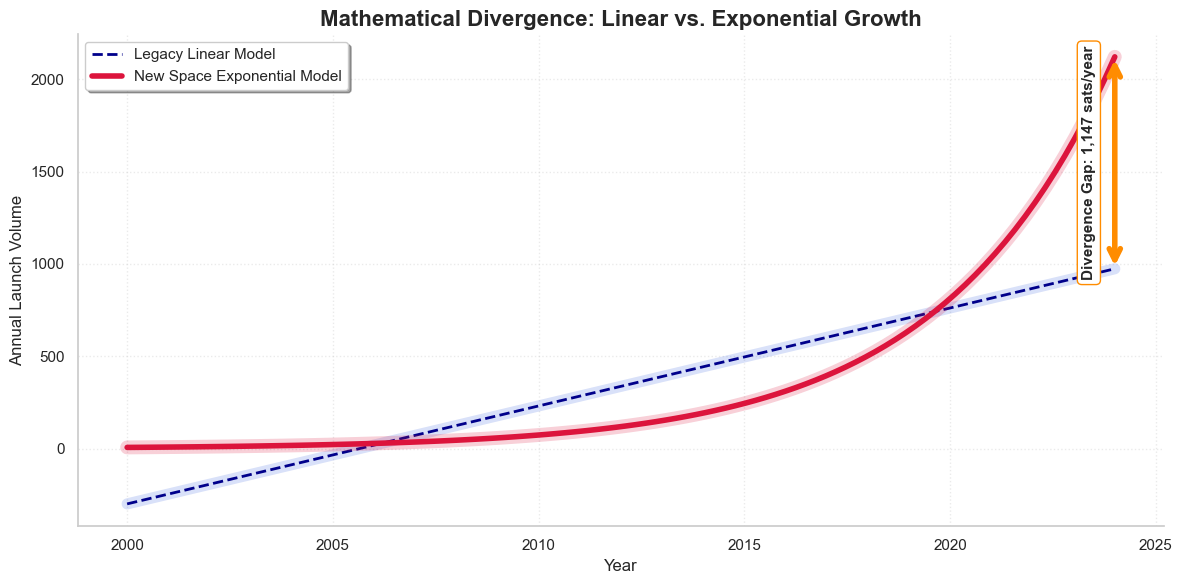

In [17]:
# --- STAGE 4.2: MODEL DIVERGENCE AUDIT ---

# 1. Define the X-axis range (The missing piece)
x_audit = np.linspace(2000, 2024, 100)

# 2. Calculate Boundary Values for the Audit
lin_2000, exp_2000 = linear_growth(2000, *popt_lin), exponential_growth(2000, *popt_exp)
lin_2024, exp_2024 = linear_growth(2024, *popt_lin), exponential_growth(2024, *popt_exp)

print(f"--- Model Divergence Audit ---")
print(f"Year 2000 Gap: {exp_2000 - lin_2000:,.1f} satellites")
print(f"Year 2024 Gap: {exp_2024 - lin_2024:,.1f} satellites")

# 3. Create the Visualization
plt.figure(figsize=(12, 6))

# Legacy Model (Blue Glow)
plt.plot(x_audit, linear_growth(x_audit, *popt_lin), color='royalblue', alpha=0.2, linewidth=8) 
plt.plot(x_audit, linear_growth(x_audit, *popt_lin), label='Legacy Linear Model', color='darkblue', linestyle='--', linewidth=2)

# New Space Model (Red Glow)
plt.plot(x_audit, exponential_growth(x_audit, *popt_exp), color='crimson', alpha=0.2, linewidth=10)
plt.plot(x_audit, exponential_growth(x_audit, *popt_exp), label='New Space Exponential Model', color='crimson', linewidth=4)

# Enhanced Divergence Gap (Orange Arrow)
plt.annotate('', xy=(2024, exp_2024), xytext=(2024, lin_2024),
             arrowprops=dict(arrowstyle='<->', color='darkorange', lw=4, mutation_scale=20))

plt.text(2023.2, (exp_2024 + lin_2024)/2, f'Divergence Gap: {exp_2024 - lin_2024:,.0f} sats/year', 
         rotation=90, verticalalignment='center', fontweight='bold', fontsize=11,
         bbox=dict(facecolor='white', edgecolor='darkorange', boxstyle='round,pad=0.3'))

# Formatting
plt.title('Mathematical Divergence: Linear vs. Exponential Growth', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Annual Launch Volume', fontsize=12)
plt.grid(True, which='both', linestyle=':', alpha=0.4)
plt.legend(loc='upper left', frameon=True, shadow=True)

sns.despine()
plt.tight_layout()
plt.show()

### **Stage 4.3: Identifying the Acceleration Point (Slope Analysis)**
**The Problem:** Because the "New Space" surge is so aggressive, the exponential model remained consistently above the linear legacy model for the duration of the search window (2000–2024). A simple intersection (where the lines cross) does not exist in this era.

**The Solution:** We shift our focus from **Volume** (where the lines cross) to **Velocity** (where the growth rates cross). By calculating the first derivative (the slope) of both models, we can identify the exact "Acceleration Point."

**The Logic:**
* **Linear Slope ($m$):** Represents the steady, historical cadence of legacy spaceflight.
* **Exponential Slope ($f'(x)$):** Represents the accelerating rate of deployments in the commercial era.
* **The Acceleration Point:** The specific year where the exponential growth rate officially became steeper than the legacy linear trend, signaling a fundamental regime shift in orbital density.

In [18]:
linear_slope = popt_lin[0]

# 3. Solve for the year where Exponential Slope = Linear Slope
def slope_diff(x):
    return exponential_slope(x, *popt_exp) - linear_slope

# Perform the calculation within our modern window
acceleration_year = brentq(slope_diff, 2000, 2024)
sat_count_at_accel = exponential_growth(acceleration_year, *popt_exp)

print(f"--- Acceleration Audit ---")
print(f"Growth Rate Surpassed: {acceleration_year:.2f}")
print(f"Annual Volume at Point: {sat_count_at_accel:.0f} satellites")

--- Acceleration Audit ---
Growth Rate Surpassed: 2014.57
Annual Volume at Point: 221 satellites


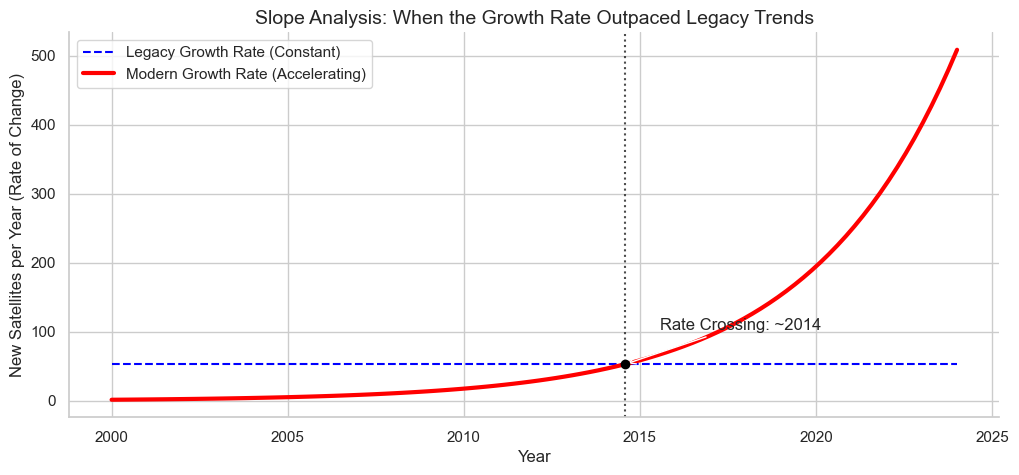

In [19]:
# Create the slope data
x_slope = np.linspace(2000, 2024, 100)
y_slope_lin = [popt_lin[0]] * 100 # Constant slope for linear
y_slope_exp = [exponential_slope(x, *popt_exp) for x in x_slope]

plt.figure(figsize=(12, 5))

# Plot the slopes
plt.plot(x_slope, y_slope_lin, label='Legacy Growth Rate (Constant)', color='blue', linestyle='--')
plt.plot(x_slope, y_slope_exp, label='Modern Growth Rate (Accelerating)', color='red', linewidth=3)

# Mark the Acceleration Point (2014)
plt.axvline(x=acceleration_year, color='black', linestyle=':', alpha=0.7)
plt.scatter([acceleration_year], [linear_slope], color='black', zorder=5)

plt.title('Slope Analysis: When the Growth Rate Outpaced Legacy Trends', fontsize=14)
plt.ylabel('New Satellites per Year (Rate of Change)')
plt.xlabel('Year')
plt.legend()

plt.annotate(f'Rate Crossing: ~{int(acceleration_year)}', 
             xy=(acceleration_year, linear_slope), 
             xytext=(acceleration_year + 1, linear_slope + 50),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

sns.despine()
plt.show()

### **Stage 4.4: Visualizing Observation vs. Model**
**The Problem:** Simple scatter plots can under-represent the sheer volume of deployments as they scale, making it difficult to visualize the exact moment the "New Space" era diverged from historical norms.

**The Solution:** Implement a **Hybrid Volume/Trend Visualization**:
1. **Annual Volume (Bars):** Provides a physical sense of the increasing launch "load" on the orbital environment.
2. **The Exponential Gap (Fill):** Highlighting the area between the linear and exponential models to visualize the "Surplus" of objects added in the last decade.
3. **High-Contrast Layering:** Using distinct colors to differentiate between historical baseline trends and current risks.

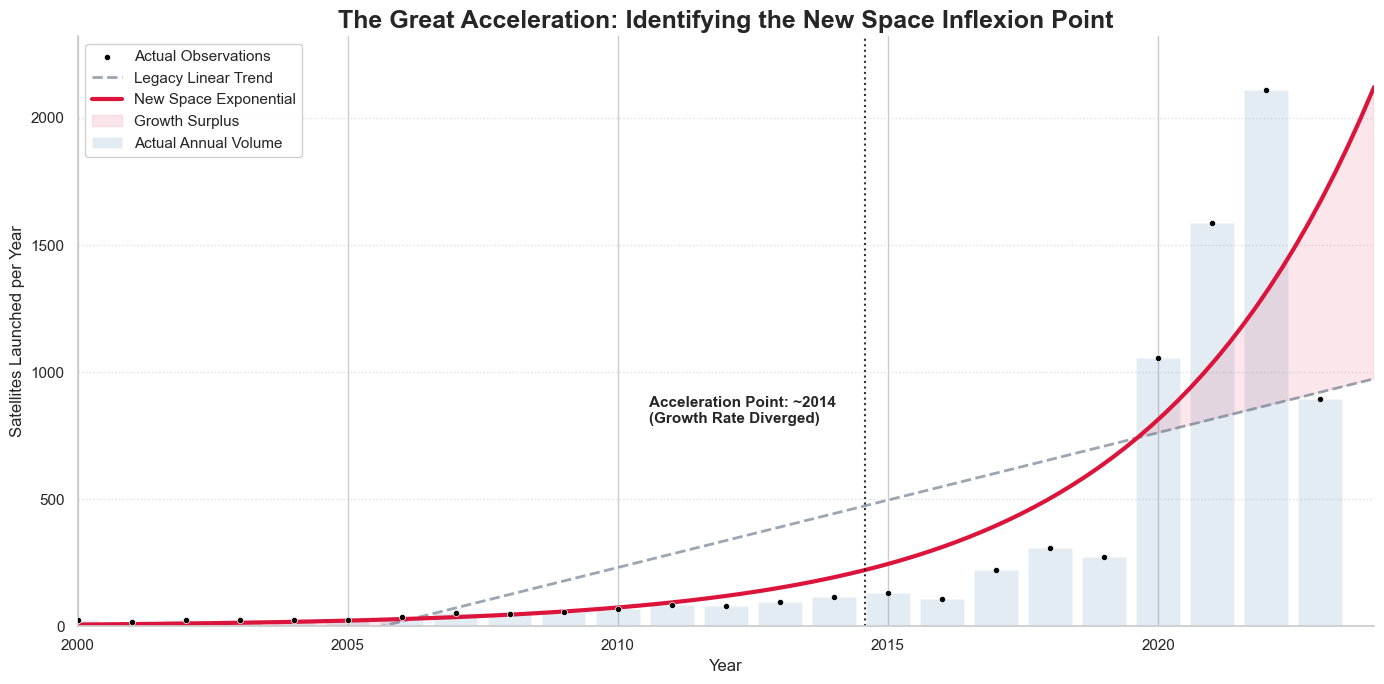

In [20]:
# --- STAGE 4.4: THE FINAL SYNTHESIS PLOT ---

# 1. Ensure Plotting Variables are Defined (Fixes NameError)
x_fit = np.linspace(2000, 2024, 100)
y_lin_pred = linear_growth(x_fit, *popt_lin)
y_exp_pred = exponential_growth(x_fit, *popt_exp)

plt.figure(figsize=(14, 7))

# 2. Volume and Data Points
plt.bar(yearly_counts['launch_year'], yearly_counts['satellite_name'], 
        color='steelblue', alpha=0.15, label='Actual Annual Volume')

plt.scatter(yearly_counts['launch_year'], yearly_counts['satellite_name'], 
            color='black', s=20, edgecolors='white', linewidth=0.5, label='Actual Observations', zorder=5)

# 3. Model Lines
plt.plot(x_fit, y_lin_pred, label='Legacy Linear Trend', 
         color='slategray', linestyle='--', linewidth=2, alpha=0.7)

plt.plot(x_fit, y_exp_pred, label='New Space Exponential', 
         color='crimson', linestyle='-', linewidth=3)

# "Acceleration Point" annotation
plt.axvline(x=acceleration_year, color='black', linestyle=':', alpha=0.8, linewidth=1.5)
plt.annotate(f'Acceleration Point: ~{int(acceleration_year)}\n(Growth Rate Diverged)', 
             xy=(acceleration_year, sat_count_at_accel), 
             xytext=(acceleration_year - 4, 800),
             arrowprops=dict(facecolor='black', arrowstyle='->', connectionstyle="arc3,rad=.2", alpha=0.6),
             fontsize=11, fontweight='bold')

# 5. Shade the "Exponential Risk Surplus"
plt.fill_between(x_fit, y_lin_pred, y_exp_pred, 
                 where=(y_exp_pred > y_lin_pred), 
                 color='crimson', alpha=0.1, label='Growth Surplus')

# Formatting
plt.title('The Great Acceleration: Identifying the New Space Inflexion Point', fontsize=18, fontweight='bold')
plt.ylabel('Satellites Launched per Year', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xlim(2000, 2024)
plt.ylim(0, yearly_counts['satellite_name'].max() * 1.1)

plt.grid(axis='y', linestyle=':', alpha=0.6)
plt.legend(frameon=True, facecolor='white', framealpha=0.9, loc='upper left')

sns.despine()
plt.tight_layout()

plt.savefig('../../images/great_acceleration.png') # Save this new impactful visual
plt.show()

In [21]:
# --- FINAL METRIC VALIDATION ---
print(f"{'Metric':<30} | {'Value':<20}")
print("-" * 55)
print(f"{'Acceleration Year':<30} | {int(acceleration_year)}")
print(f"{'Volume at Acceleration':<30} | {int(sat_count_at_accel)} sats/year")
print(f"{'Current Year (2024) Projection':<30} | {int(y_exp_pred[-1])} sats/year")
print(f"{'Estimated Risk Surplus (2024)':<30} | {int(y_exp_pred[-1] - y_lin_pred[-1])} satellites")

Metric                         | Value               
-------------------------------------------------------
Acceleration Year              | 2014
Volume at Acceleration         | 221 sats/year
Current Year (2024) Projection | 2120 sats/year
Estimated Risk Surplus (2024)  | 1147 satellites


### **Discovery Summary: The 2014 Orbital Regime Shift**

**The Findings:**
Our analysis confirms that the orbital environment reached a critical **Acceleration Point in 2014**. At this juncture, the deployment rate of active satellites surged to **221 units per year**, signaling the moment where the "New Space" exponential growth curve ($y = ab^x$) officially decoupled from the 20th-century linear model ($y = mx + b$).

**The "Risk Surplus":**
The shaded region in our model represents the **Exponential Risk Surplus**. This volume represents thousands of active payloads—primarily commercial mega-constellations—that exist entirely outside of historical management norms. This population is now pulling away from legacy safety models at an accelerating rate.

**The Kessler Implication:**
This divergence is not a statistical anomaly; it is a fundamental shift in the **Collision Probability Matrix**. While debris mitigation strategies were designed for a stable, linear environment, we are now operating in a high-velocity, exponential one.

**Conclusion & Strategic Hand-off:**
With the active "Input Rate" confirmed, we have identified the primary driver of future congestion. However, active satellites represent only a fraction of the total kinetic risk. To quantify the full threat, we must now bridge this data with the **Full SATCAT Master Registry**.

In **`satcat_eda.ipynb`**, we will audit the **"Invisible Population"**—the decades of abandoned rocket bodies and "Zombie" payloads—to calculate the total mass density (Kinetic Fuel) currently residing in the Kessler Canyon.